In [2]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import date
import statistics
from IPython.display import Markdown
import calmap

In [3]:
# Load our CSV file into a dataframe.
YEAR = 2022
time_entries = pd.read_csv(
    f"past_data/Toggl_time_entries_{YEAR}-01-01_to_{YEAR}-12-31.csv", 
    parse_dates=["Start date", "End date"],
    date_format="%Y-%m-%d",
)
print(f'Data has {time_entries.shape[0]} rows and {time_entries.shape[1]} columns')
time_entries.head()

Data has 275 rows and 13 columns


,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags
0,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-01-19,00:54:00,2022-01-19,08:03:00,07:09:00,NaN
1,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-01-29,01:54:00,2022-01-29,02:24:00,00:30:00,NaN
2,小透明233,shenmingxin2000@gmail.com,personal,记录计划,NaN,nian，写日记,No,2022-02-04,03:45:00,2022-02-04,04:16:00,00:31:00,NaN
3,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-02-04,05:03:00,2022-02-04,11:43:00,06:40:00,NaN
4,小透明233,shenmingxin2000@gmail.com,personal,娱乐,NaN,哔哩哔哩，影视解说,No,2022-02-04,16:21:01,2022-02-04,16:45:54,00:24:53,NaN


In [4]:
# Filter data by date (`start_date` inclusive, `end_date` exclusive).
start_date = f'{YEAR}-01-01'
end_date = f'{YEAR + 1}-01-01'
time_entries = time_entries[(time_entries['Start date'] >= start_date) & (time_entries['End date'] < end_date)]
print(f'Data has {time_entries.shape[0]} rows after filtering.')
time_entries.head()

Data has 275 rows after filtering.


,User,Email,Client,Project,Task,Description,Billable,Start date,Start time,End date,End time,Duration,Tags
0,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-01-19,00:54:00,2022-01-19,08:03:00,07:09:00,NaN
1,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-01-29,01:54:00,2022-01-29,02:24:00,00:30:00,NaN
2,小透明233,shenmingxin2000@gmail.com,personal,记录计划,NaN,nian，写日记,No,2022-02-04,03:45:00,2022-02-04,04:16:00,00:31:00,NaN
3,小透明233,shenmingxin2000@gmail.com,later,睡眠,NaN,NaN,No,2022-02-04,05:03:00,2022-02-04,11:43:00,06:40:00,NaN
4,小透明233,shenmingxin2000@gmail.com,personal,娱乐,NaN,哔哩哔哩，影视解说,No,2022-02-04,16:21:01,2022-02-04,16:45:54,00:24:53,NaN


In [5]:
# Drop unneeded columns.
time_entries = time_entries.drop(['User', 'Email', 'Client', 'Task', 'Billable', 'Tags'], axis=1)

In [6]:
# Toggl provides the data with dates and times separated. We need to combine them back together.
# First, we convert the "Start time" and "End time" columns to `pandas.dt.time`. 
time_entries['Start time'] = pd.to_datetime(time_entries['Start time'], format="%H:%M:%S").dt.time
time_entries['End time'] = pd.to_datetime(time_entries['End time'], format="%H:%M:%S").dt.time
# Then we use `pd.Timestamp.combine()` to combine the date and time columns into new column called "Start" and "End". 
time_entries['Start'] = time_entries.apply(lambda x: pd.Timestamp.combine(x['Start date'], x['Start time']), axis=1)
time_entries['End'] = time_entries.apply(lambda x: pd.Timestamp.combine(x['End date'], x['End time']), axis=1)
# Finally, we remove the original columns.
time_entries = time_entries.drop(['Start date', 'Start time', 'End date', 'End time'], axis=1)

# Recalculate the "Duration" column so that we get instances of `pandas.Timedelta`.
time_entries['Duration'] = time_entries['End'] - time_entries['Start']

time_entries.head()

,Project,Description,Duration,Start,End
0,睡眠,NaN,0 days 07:09:00,2022-01-19 00:54:00,2022-01-19 08:03:00
1,睡眠,NaN,0 days 00:30:00,2022-01-29 01:54:00,2022-01-29 02:24:00
2,记录计划,nian，写日记,0 days 00:31:00,2022-02-04 03:45:00,2022-02-04 04:16:00
3,睡眠,NaN,0 days 06:40:00,2022-02-04 05:03:00,2022-02-04 11:43:00
4,娱乐,哔哩哔哩，影视解说,0 days 00:24:53,2022-02-04 16:21:01,2022-02-04 16:45:54


In [7]:
time_entries['Project'].unique()

array(['睡眠', '记录计划', '娱乐', 'Maths Undergraduate', '生活', '阅读写作', '折腾',
       'UROP', 'Career', nan], dtype=object)

In [8]:
# Add a tag to each entry stating whether it's work-related, study-related, or hobby-related.
def get_tag(project_name: str) -> str:
    if project_name in ('AI CDT', 'Research', 'Email', 'Literature reading', 'PhD Application', 'Master Thesis'):
        return 'Work'
    elif project_name in ('AI', 'Data Engineering', 'Distributed Systems', "Master's Thesis", 'Other Uni'):
        return 'Study'
    elif project_name in ('Guitar', 'Personal Projects', 'Sport'):
        return 'Hobby'
    else:
        # raise ValueError(f'Unhandled project: "{project_name}".')
        return 'Other'

time_entries['Tag'] = time_entries.apply(lambda r: get_tag(r['Project']), axis=1)
time_entries

,Project,Description,Duration,Start,End,Tag
0,睡眠,NaN,0 days 07:09:00,2022-01-19 00:54:00,2022-01-19 08:03:00,Other
1,睡眠,NaN,0 days 00:30:00,2022-01-29 01:54:00,2022-01-29 02:24:00,Other
2,记录计划,nian，写日记,0 days 00:31:00,2022-02-04 03:45:00,2022-02-04 04:16:00,Other
3,睡眠,NaN,0 days 06:40:00,2022-02-04 05:03:00,2022-02-04 11:43:00,Other
4,娱乐,哔哩哔哩，影视解说,0 days 00:24:53,2022-02-04 16:21:01,2022-02-04 16:45:54,Other
...,...,...,...,...,...,...
270,NaN,突发 BRP report lost,0 days 00:59:39,2022-10-29 14:45:35,2022-10-29 15:45:14,Other
271,生活,生活 洗手洗脸洗澡洗头,0 days 01:00:12,2022-10-29 16:55:28,2022-10-29 17:55:40,Other
272,Career,设定一个集中申请改简历、做 OT 的时间段,0 days 00:28:48,2022-10-29 19:39:26,2022-10-29 20:08:14,Other
273,记录计划,写日记,0 days 00:13:32,2022-10-30 01:06:12,2022-10-30 01:19:44,Other


In [9]:
# Generate a Markdown table with some basic statistics.
table = "| Project | Num Entries | Time Tracked | Avg. Duration |\n"
table += "| --- | --- | --- | --- |\n"
# Group by project and iterate over the results. 
# `groupby()` provides us with a dataframe of time entries for each project. 
for project_name, project_entries in time_entries.groupby('Project'):
    time_tracked = project_entries['Duration'].sum().total_seconds()
    avg_duration = project_entries['Duration'].mean().total_seconds()
    table += f"| {project_name} | {len(project_entries)} | {int(time_tracked // 3600)} hours | {int(avg_duration // 60)} min |\n"

total_time = time_entries['Duration'].sum().total_seconds()
avg_duration = int(total_time / len(time_entries))
table += f"| **Total** | **{len(time_entries)}** | **{int(total_time // 3600)} hours** | **{int(avg_duration // 60)} min** |\n"

Markdown(table)

| Project | Num Entries | Time Tracked | Avg. Duration |
| --- | --- | --- | --- |
| Career | 33 | 11 hours | 21 min |
| Maths Undergraduate | 67 | 31 hours | 28 min |
| UROP | 5 | 1 hours | 21 min |
| 娱乐 | 26 | 22 hours | 51 min |
| 折腾 | 7 | 1 hours | 10 min |
| 生活 | 73 | 25 hours | 20 min |
| 睡眠 | 16 | 59 hours | 221 min |
| 记录计划 | 38 | 9 hours | 15 min |
| 阅读写作 | 9 | 1 hours | 7 min |
| **Total** | **275** | **164 hours** | **35 min** |


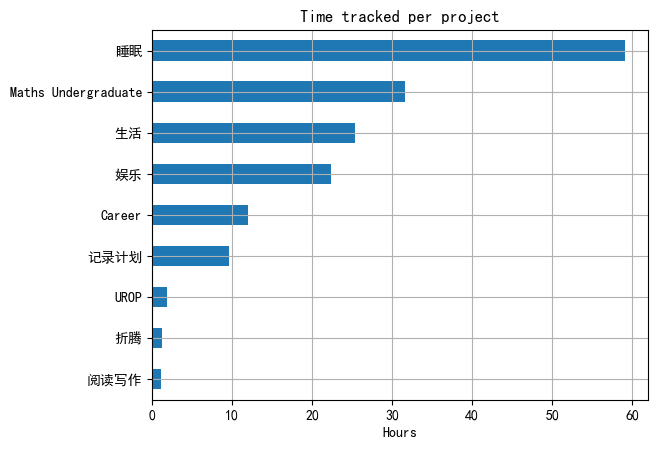

In [10]:
# Make a simple bar plot of time spent per project.
plt.rcParams['font.family'] = 'SimHei' # Microsoft YaHei

time_spent = time_entries.groupby('Project')['Duration'].sum().dt.total_seconds() / 3600
time_spent.sort_values(inplace=True)

ax = time_spent.plot.barh()
ax.set_title('Time tracked per project')
ax.set_xlabel('Hours')
ax.set_ylabel('')
ax.grid()

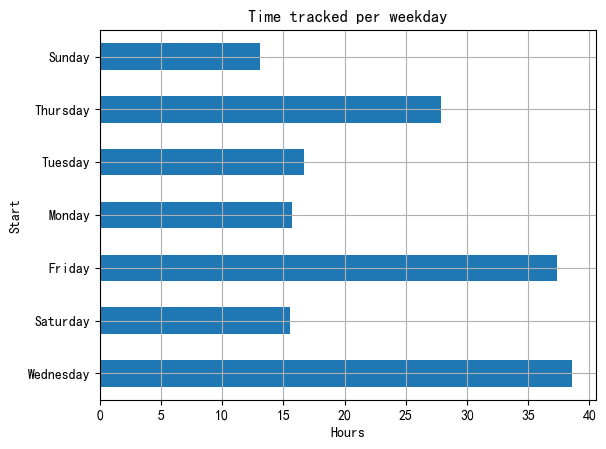

In [11]:
# Group time entries by the weekday on which they were recorded.
per_weekday = time_entries.groupby(time_entries['Start'].dt.day_name(), sort=False)['Duration'].sum().dt.total_seconds() / 3600
ax = per_weekday.plot.barh()
ax.set_title('Time tracked per weekday')
ax.set_xlabel('Hours')
ax.grid()

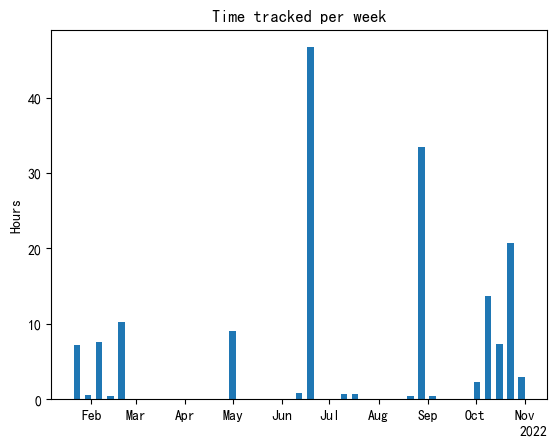

In [12]:
# Calculate the total time tracked per week.
# We use a Grouper for this. See https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
per_week = time_entries.groupby(pd.Grouper(key="Start", freq="1W"))['Duration'].sum().dt.total_seconds() / 3600
fig, ax = plt.subplots()
ax.bar(per_week.index, per_week.values, width=pd.Timedelta(4, "d"))
ax.set_title('Time tracked per week')
ax.set_ylabel('Hours')

# Configure the plot to only show ticks on each Month and ot have concise labels.
# See https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

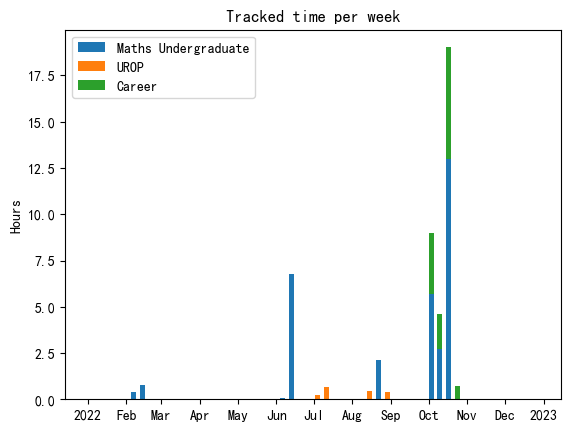

In [15]:
# Create a stacked bar plot that breaks down the time spent per tag.
# This is a bit tricky because our data doesn't necessarily have an entry for every week.

# Add a new column that stores the start time of the week that the entry occured in.
time_entries['week_start'] = time_entries['Start'].dt.to_period('W').apply(lambda r: r.start_time)
# Calculate the amount of time tracked per tag and per "week_start".
per_week = time_entries.groupby(['Project', 'week_start'])['Duration'].sum().dt.total_seconds() / 3600

# The x-axis will have the date of every week between `start_date` and `end_date`, defined previously in the notebook.
# The dates should be aligned on Monday so that they match up with the `week_start` column we just calculated.
x_dates = pd.date_range(start_date, end_date, freq='W-MON')
# Calculate a running sum corresponding to `dates`. That means that the value in `running_sum[0]` will correspond to `dates[0]`.
# We use a list comprehension that simply assigns the value "0" for every value in dates. It's the same as [0 for i in range(len(dates))].
running_sum = [0 for _ in x_dates]

fig, ax = plt.subplots()
ax.set_title('Tracked time per week')
ax.set_ylabel('Hours')
for category in ['Maths Undergraduate', 'UROP', 'Career']:
    values = [0] * len(x_dates)
    # Look up the calculated time spent for `category` for each week.
    for i, week_start in enumerate(x_dates):
        values[i] = per_week[category].get(str(week_start.date()), 0)
    # Plot the result, setting "bottom" to make it stacked.
    ax.bar(x_dates, values, bottom=running_sum, width=pd.Timedelta(4, "d"), label=category)
    # Update running sum.
    for i, v in enumerate(values):
        running_sum[i] += v

ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

(<Figure size 640x480 with 1 Axes>,
 array([<Axes: ylabel='2022'>], dtype=object))

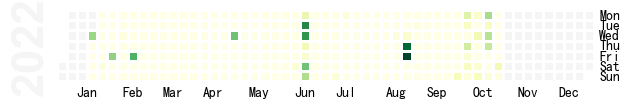

In [ ]:
# Create a heatmap of time tracked per day.
per_day = time_entries.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(per_day, cmap='YlGn')

In [ ]:
# Let's do another plot that only has study-related time entries.
work_and_study = time_entries[time_entries['Tag'] == 'Work']
work_per_day = work_and_study.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(work_per_day, cmap='YlGn')

ValueError: Number of rows must be a positive integer, not 0

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the total time spent on "Sport" entries, grouped by the description.
sports = time_entries[time_entries['Project'] == 'AI CDT']
sports.groupby('Description')['Duration'].sum().dt.total_seconds() / 3600

Description
64021 lecture videos                              0.923333
COMP61021 CW1                                    10.628611
COMP64021 lecture notes                           0.310833
COMP64401 lecture                                 1.666667
COMP69901 create group project teams, message     0.788889
COMP69901 group project discussion                1.733333
COMP69901 group project reading                   0.183333
COMP69901 meeting with Carl                       1.000000
bio learn terminalogy from PLOS paper             0.334167
group project try Jona's notebook                 0.511389
Name: Duration, dtype: float64

(<Figure size 640x480 with 1 Axes>,
 array([<Axes: ylabel='2024'>], dtype=object))

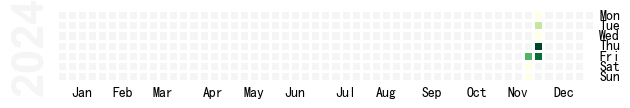

In [ ]:
# Visualize how often I played tennis.
tennis = time_entries[(time_entries['Project'] == 'AI CDT') & (time_entries['Description'].str.contains('COMP69901'))]
tennis_per_day = tennis.groupby(pd.Grouper(key="Start", freq="D"))['Duration'].sum().dt.total_seconds()
calmap.calendarplot(tennis_per_day, cmap='YlGn')

In [ ]:
time_entries.head()

,Project,Description,Duration,Start,End,Tag,week_start
0,睡眠,NaN,0 days 07:09:00,2022-01-19 00:54:00,2022-01-19 08:03:00,Other,2022-01-17
1,睡眠,NaN,0 days 00:30:00,2022-01-29 01:54:00,2022-01-29 02:24:00,Other,2022-01-24
2,记录计划,nian，写日记,0 days 00:31:00,2022-02-04 03:45:00,2022-02-04 04:16:00,Other,2022-01-31
3,睡眠,NaN,0 days 06:40:00,2022-02-04 05:03:00,2022-02-04 11:43:00,Other,2022-01-31
4,娱乐,哔哩哔哩，影视解说,0 days 00:24:53,2022-02-04 16:21:01,2022-02-04 16:45:54,Other,2022-01-31


    Project Description        Duration               Start  \
0        睡眠         NaN 0 days 07:09:00 2022-01-19 00:54:00   
1        睡眠         NaN 0 days 00:30:00 2022-01-29 01:54:00   
3        睡眠         NaN 0 days 06:40:00 2022-02-04 05:03:00   
6        睡眠         NaN 0 days 05:30:00 2022-02-18 07:25:00   
12       睡眠          困了 0 days 02:22:08 2022-02-18 15:05:19   
17       睡眠         NaN 0 days 08:33:19 2022-04-27 10:14:41   
44       睡眠         NaN 0 days 04:56:00 2022-06-14 05:04:00   
48       睡眠         NaN 0 days 01:25:17 2022-06-14 13:44:58   
60       睡眠         NaN 0 days 00:20:09 2022-06-14 22:04:47   
72       睡眠         NaN 0 days 06:05:00 2022-06-15 04:15:00   
74       睡眠         NaN 0 days 01:30:00 2022-06-15 12:24:00   
93       睡眠         NaN 0 days 05:35:00 2022-06-18 05:41:00   
104      睡眠         NaN 0 days 06:00:17 2022-06-19 04:00:05   
145      睡眠          小憩 0 days 01:30:00 2022-08-26 16:55:00   
170      睡眠          小憩 0 days 00:22:50 2022-10-03 15:2

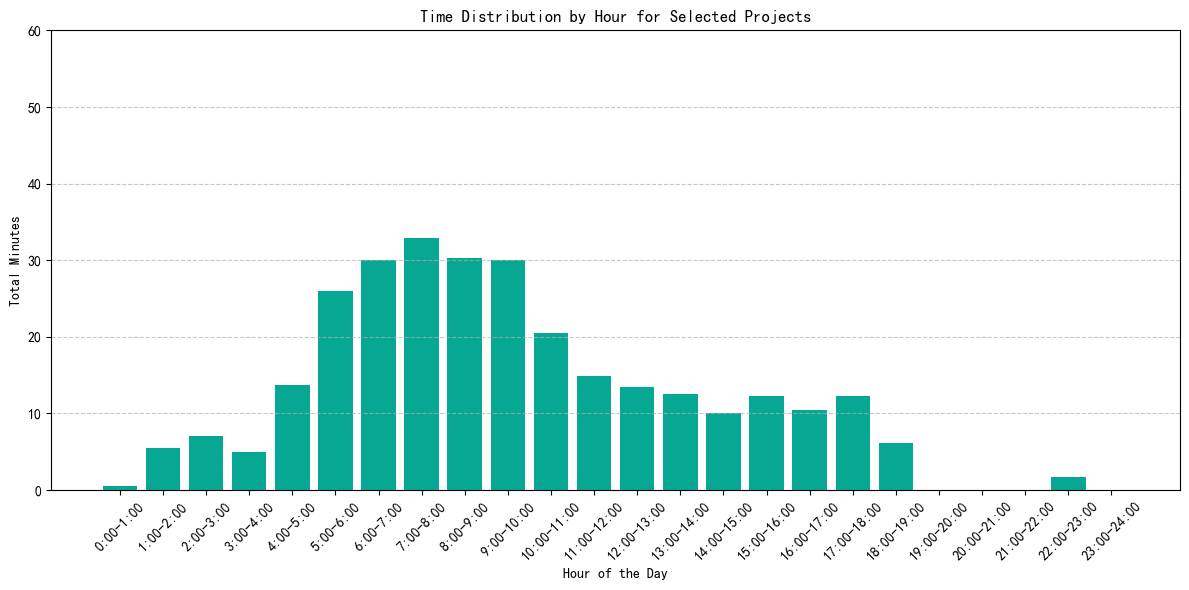

array([ 0.5       ,  5.5       ,  7.        ,  5.        , 13.74305556,
       26.        , 30.        , 32.91666667, 30.25      , 30.        ,
       20.47361111, 14.91666667, 13.46805556, 12.56805556, 10.        ,
       12.31388889, 10.41666667, 12.2875    ,  6.08333333,  0.        ,
        0.        ,  0.        ,  1.67916667,  0.        ])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

def count_days(df, start_hour=0):
    """
    Count the number of days that have at least one entry in `df`. Consider a day to be from `start_hour` to `start_hour` the next day.
    """
    # if 'Start' is earlier than `start_hour`, we consider it to be part of the previous day.
    df['start_day'] = df['Start'].dt.floor('d') + pd.to_timedelta((df['Start'].dt.hour < start_hour).astype(int), unit='d')
    # if 'End' is earlier than `start_hour`, we consider it to be part of the previous day.
    df['end_day'] = df['End'].dt.floor('d') + pd.to_timedelta((df['End'].dt.hour < start_hour).astype(int), unit='d')
    
    # Combine start_day and end_day to get all unique days
    unique_days = pd.concat([df['start_day'], df['end_day']]).unique()
    
    return len(unique_days)

# 假设 df 是之前创建的 DataFrame
# 筛选出指定的 project_name
def hourly_chart(df, filter, normalised=False):
    filtered_df = df.copy()
    for _, key in enumerate(filter):
                filtered_df = filtered_df[filtered_df[key].isin(filter[key])]
    # 初始化一个字典，用于存储每个小时的时间贡献
    hourly_distribution = np.zeros(24)
    print(filtered_df)
    # 遍历筛选后的数据
    for _, row in filtered_df.iterrows():
        start = row['Start']
        stop = row['End']
        duration = (stop - start).total_seconds() / 60  # 将持续时间转换为分钟

        # 对 start 向后取整小时
        start_ceil = start.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)
        
        # 对 stop 向前取整小时
        stop_floor = stop.replace(minute=0, second=0, microsecond=0)
        
        # 如果 start_ceil > stop_floor，说明没有完整的整小时区间
        if start_ceil > stop_floor:
            # 只有部分区间，直接计算 start 到 stop 的时间贡献
            segment_duration = (stop - start).total_seconds() / 60
            hour = start.hour
            hourly_distribution[hour] += segment_duration
        else:
            # 处理 start 到 start_ceil 的部分区间
            segment_duration = (start_ceil - start).total_seconds() / 60
            hour = start.hour
            hourly_distribution[hour] += segment_duration
            
            # 处理 stop_floor 到 stop 的部分区间
            segment_duration = (stop - stop_floor).total_seconds() / 60
            hour = stop.hour
            hourly_distribution[hour] += segment_duration
            
            # 处理中间的完整小时区间
            full_hours = np.arange(start_ceil.hour, stop_floor.hour)  # 完整的小时区间
            hourly_distribution[full_hours] += 60  # 每个完整小时 +60 分钟

    if normalised:
        days = count_days(filtered_df)
        hourly_distribution /= days 

    # 绘制条状图
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(24),hourly_distribution, color='#06a893')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Minutes')
    if normalised:
        plt.ylim(0, 60)
    plt.title('Time Distribution by Hour for Selected Projects')
    plt.xticks(range(24), [f'{hour}:00-{hour+1}:00' for hour in range(24)], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return hourly_distribution
    

hourly_chart(time_entries, {"Project":["睡眠"]}, normalised=21)